## Calculate SSH-based Gulf Stream Index using CMEMS satellite data 0.25 deg
### CMEMS product: Global Ocean Gridded L 4 Sea Surface Heights And Derived Variables Reprocessed 1993 Ongoing (Product ID: SEALEVEL_GLO_PHY_L4_MY_008_047; https://doi.org/10.48670/moi-00148)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zhuomin_2new_tools

In [2]:
### satellite CMEMS SLA data
# Available from 1993.01 to 2023.05; checked on Nov. 20th, 2024
# Area range: 32°-51°N; 80-40°W
# Note: Daily dataset is downloaded here; but you can directly download the monthly dataset
sla_month = np.ma.zeros([2024-1993, 12, 76, 134]); sla_month.mask = True
path = '/glade/work/czhuomin/MAPP/CMEMS/DATA'
filename = f'{path}/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_sla_32-51N_80-40W_19930101-20230531.nc'
ds = xr.open_dataset(filename)
sla = ds['sla'][:, :, 7:-19].values # 11108, 76, 134
lat = ds['latitude'][:].values
lon = ds['longitude'][7:-19].values
ds.close()
#
lyy = 0
for year in range(1993, 2024):
    nyy, dm = zhuomin_2new_tools.leapyear(year)
    dmm = [0] + list(np.cumsum(dm))
    # select data within a particular year
    if lyy + nyy <= np.shape(sla)[0]:
        sla_year = np.ma.array(sla[lyy:lyy+nyy, :, :], mask=np.isnan(sla[lyy:lyy+nyy, :, :]))
        # monthly average
        for mm in range(12):
            sla_month[year-1993, mm, :, :] = sla_year[dmm[mm]:dmm[mm+1], :, :].mean(axis=0)
        #
        lyy = lyy + nyy
    else:
        sla_year = np.ma.array(sla[lyy:, :, :], mask=np.isnan(sla[lyy:, :, :]))
        # monthly average
        for mm in range(12):
            if dmm[mm+1] <= (np.shape(sla)[0]-lyy):
                sla_month[year-1993, mm, :, :] = sla_year[dmm[mm]:dmm[mm+1], :, :].mean(axis=0)

### calculate Gulf Stream SSH-based main axis & SSH-based GSI

In [3]:
# calculate SSH max STD meridionally
sla_month_select = np.ma.reshape(sla_month[:2018-1993,:], [(2018-1993)*12, 76, 134]) # 1993-2018
sla_std_m = np.ma.std(sla_month_select, axis=0)

In [4]:
# obtain latitudinal positions that have the max std meridionally
lat_sla_max_std_m = np.ma.zeros(np.shape(sla_std_m)[1])
lat_sla_max_std_m.mask = True
#
for ii in range(np.shape(sla_std_m)[1]):
    lat_sla_max_std_m[ii] = lat[np.ma.argmax(sla_std_m[:, ii])]
# select points between 72°W and 52°W with 1° resolution
print(lon[26:134-29:4])
print(lat_sla_max_std_m[26:134-29:4])

[-71.625 -70.625 -69.625 -68.625 -67.625 -66.625 -65.625 -64.625 -63.625
 -62.625 -61.625 -60.625 -59.625 -58.625 -57.625 -56.625 -55.625 -54.625
 -53.625 -52.625]
[37.125 37.375 37.625 37.625 37.625 37.875 38.125 38.125 38.875 39.125
 39.625 39.375 39.375 39.625 39.875 39.875 39.875 39.875 39.625 39.625]


In [5]:
# obtain index location for the selected points
sla_21_points = np.ma.zeros([len(lon[26:134-29:4]), 2024-1993, 12])
sla_21_points.mask = True
jj = 0
for ii in range(26, 134-29, 4):
    locx = np.where(lon == lon[ii])[0][0]
    locy = np.where(lat == lat_sla_max_std_m[ii])[0][0]
    sla_21_points[jj] = sla_month[:, :, locy, locx].copy()
    #
    jj = jj + 1
#
sla_21_points = sla_21_points.reshape([len(lon[26:134-29:4]), (2024-1993)*12])

In [6]:
# average the SLA across all the selected points
sla_21_points = sla_21_points.mean(axis=0)
# normalized the averaged SLA time series and obtain the SSH-based GSI
gsi_sla = (sla_21_points - sla_21_points.mean())/sla_21_points.std()

In [7]:
# save the SSH-based GSI
dsf = xr.Dataset()
dsf['GSI'] = gsi_sla
dsf.load()
# save to .nc file
outpath = '/glade/work/czhuomin/MAPP/CMEMS/DATA'
dsf.to_netcdf(f'{outpath}/SSH-based_GSI_72-52W_199301-202305_monthly.nc', mode='w')

In [8]:
# save to .csv file
yrmn = [list(np.arange(year+.01, year+.129, 0.01)) for year in range(1993, 2024)]
yrmn = ['%.2f' % j for sub in yrmn for j in sub]
data = {'year.month': yrmn,
        'SSH-based GSI': gsi_sla}
df = pd.DataFrame(data)
df.to_csv(f'{outpath}/SSH-based_GSI_72-52W_199301-202305_monthly.csv')

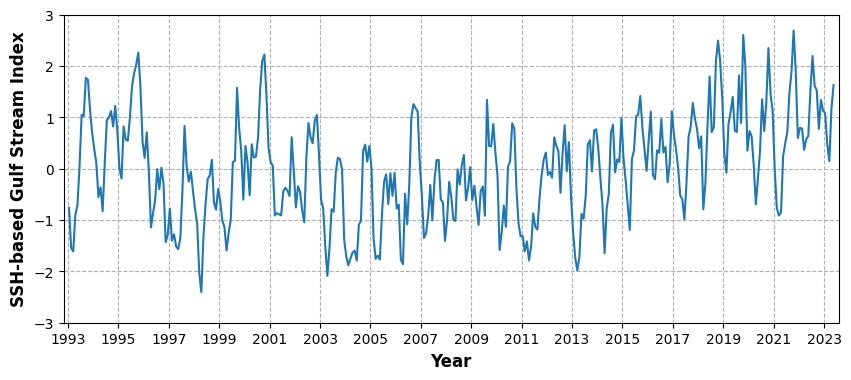

In [9]:
# plot the SSH-based GSI
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)
ax.plot(np.arange(1993+1/24., 2024, 1/12.), gsi_sla, label='Satellite')
#ax.legend(loc=0,ncol=1)
ax.set_xlim(1992+10/12., 2024-5/12.)
ax.set_ylim(-3, 3)
ax.set_xticks(range(1993, 2025, 2))
ax.set_ylabel('SSH-based Gulf Stream Index', fontsize=12, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.grid(linestyle='dashed')
# save fig
output = '/glade/work/czhuomin/MAPP/CMEMS/PLOTS'
outfile = '%s/SSH-based_GSI_72-52W_199301-202305_monthly.png' % (output)
plt.savefig(outfile, dpi=400, facecolor='w', edgecolor='w', orientation='portrait')
#
plt.show()